Device: cuda
[15:32:33] Episode 0, Reward: -85.71, RecentAvg(50): -85.706, Epsilon: 0.995, ReplayLen: 14
[15:32:41] Episode 50, Reward: -134.99, RecentAvg(50): -116.672, Epsilon: 0.774, ReplayLen: 1540
[15:32:49] Episode 100, Reward: -236.03, RecentAvg(50): -131.536, Epsilon: 0.603, ReplayLen: 3466
[15:32:59] Episode 150, Reward: -168.15, RecentAvg(50): -134.566, Epsilon: 0.469, ReplayLen: 5457
[15:33:10] Episode 200, Reward: -130.79, RecentAvg(50): -149.195, Epsilon: 0.365, ReplayLen: 7817
[15:33:21] Episode 250, Reward: -227.89, RecentAvg(50): -150.113, Epsilon: 0.284, ReplayLen: 10159
[15:33:34] Episode 300, Reward: -219.32, RecentAvg(50): -164.698, Epsilon: 0.221, ReplayLen: 12823
[15:33:51] Episode 350, Reward: -236.54, RecentAvg(50): -186.134, Epsilon: 0.172, ReplayLen: 16015
[15:34:09] Episode 400, Reward: -99.48, RecentAvg(50): -198.281, Epsilon: 0.134, ReplayLen: 19496
[15:34:23] Episode 450, Reward: -103.10, RecentAvg(50): -162.081, Epsilon: 0.104, ReplayLen: 20000
[15:34:32]

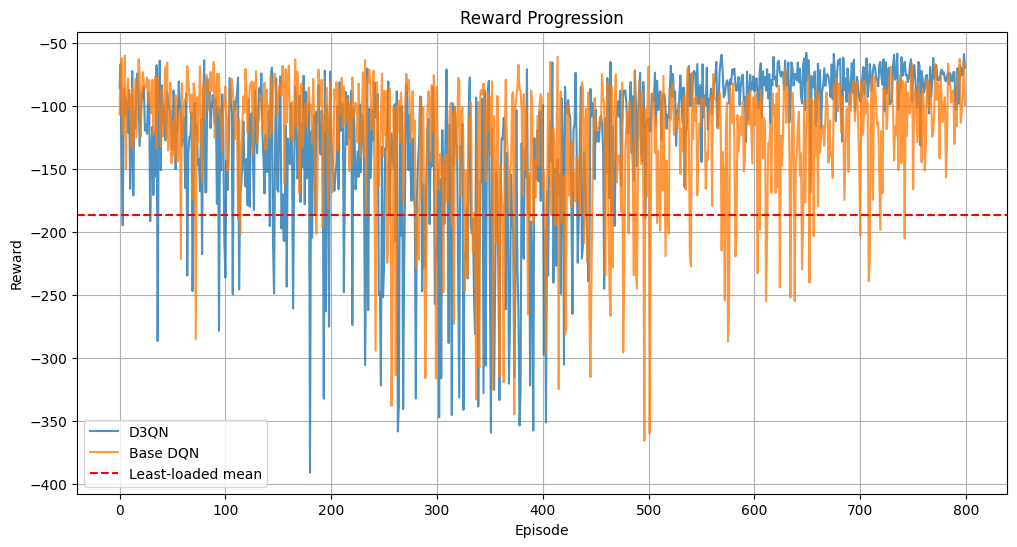

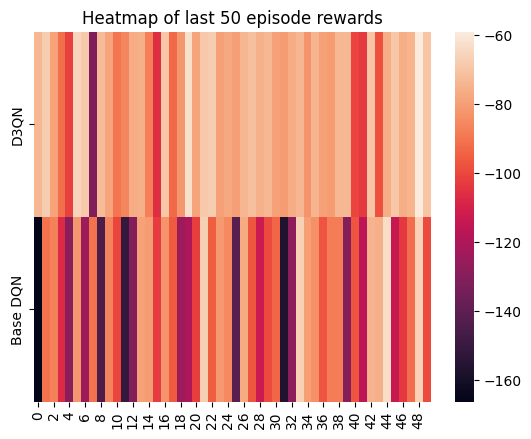

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [9]:
import gym
from gym import spaces
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import time
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# =========================
# 0. Seed setup
# =========================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# =========================
# 1. Edge Resource Environment
# =========================
class EdgeResourceEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, num_nodes=3, capacity=100.0, base_latency=1.0,
                 base_decay_rate=0.1, decay_jitter=0.03,
                 latency_penalty_power=2.0, overload_penalty_factor=5.0,
                 overload_threshold_factor=0.9, catastrophic_factor=1.1):
        super().__init__()
        self.num_nodes = num_nodes
        self.capacity = capacity
        self.base_latency = base_latency
        self.base_decay_rate = base_decay_rate
        self.decay_jitter = decay_jitter
        self.latency_penalty_power = latency_penalty_power
        self.overload_penalty_factor = overload_penalty_factor
        self.overload_threshold = overload_threshold_factor * self.capacity
        self.catastrophic_threshold = catastrophic_factor * self.capacity

        self.action_space = spaces.Discrete(num_nodes)
        self.observation_space = spaces.Box(low=0.0, high=1.0, shape=(num_nodes + 1,), dtype=np.float32)
        self.reset()

    def reset(self):
        self.node_loads = np.zeros(self.num_nodes, dtype=np.float32)
        self.current_task = self._generate_task()
        return self._get_state()

    def _generate_task(self):
        if random.random() < 0.12:
            return float(np.random.randint(40, 60))
        else:
            return float(max(5.0, np.random.normal(15.0, 6.0)))

    def _get_state(self):
        normalized_loads = np.clip(self.node_loads / self.capacity, 0.0, 1.0)
        norm_task = np.clip(self.current_task / self.capacity, 0.0, 1.0)
        return np.concatenate([normalized_loads, [norm_task]]).astype(np.float32)

    def step(self, action):
        current_decay_rate = self.base_decay_rate + np.random.uniform(-self.decay_jitter, self.decay_jitter)
        self.node_loads *= (1.0 - current_decay_rate)
        task_load = float(self.current_task)
        projected_load = self.node_loads[action] + task_load

        frac = projected_load / self.capacity
        latency = self.base_latency + (frac ** self.latency_penalty_power)
        overload_penalty = 0.0
        if projected_load > self.overload_threshold:
            overload_penalty = -self.overload_penalty_factor * (projected_load - self.overload_threshold) / self.capacity

        loads_after = self.node_loads.copy()
        loads_after[action] += task_load
        std_penalty = -0.5 * np.std(loads_after) / self.capacity
        peak_reward = -1.0 * (np.max(loads_after) / self.capacity)

        reward = -latency + overload_penalty + std_penalty + peak_reward
        self.node_loads[action] += task_load
        done = False
        info = {"latency": latency, "task_load": task_load, "projected_load": projected_load}

        if projected_load > self.catastrophic_threshold:
            done = True
            reward -= 50.0

        self.current_task = self._generate_task()
        return self._get_state(), float(reward), done, info

    def render(self, mode='human'):
        print(f"Node loads: {self.node_loads}")

# =========================
# 2. Dueling DQN (D3QN)
# =========================
class DuelingDQN(nn.Module):
    def __init__(self, state_size, action_size, hidden=[128, 128]):
        super().__init__()
        self.fc1 = nn.Linear(state_size, hidden[0])
        self.fc2 = nn.Linear(hidden[0], hidden[1])
        self.value_fc = nn.Linear(hidden[1], 64)
        self.value_out = nn.Linear(64, 1)
        self.adv_fc = nn.Linear(hidden[1], 64)
        self.adv_out = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        v = torch.relu(self.value_fc(x))
        v = self.value_out(v)
        a = torch.relu(self.adv_fc(x))
        a = self.adv_out(a)
        return v + (a - a.mean(dim=1, keepdim=True))

# =========================
# 3. Prioritized Replay Buffer
# =========================
class PrioritizedReplayBuffer:
    def __init__(self, capacity=20000, alpha=0.6, eps=1e-6):
        self.capacity = capacity
        self.alpha = alpha
        self.eps = eps
        self.buffer = []
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.pos = 0

    def push(self, state, action, reward, next_state, done):
        max_prio = self.priorities.max() if self.buffer else 1.0
        if len(self.buffer) < self.capacity:
            self.buffer.append((state, action, reward, next_state, done))
        else:
            self.buffer[self.pos] = (state, action, reward, next_state, done)
        self.priorities[self.pos] = max_prio
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size, beta=0.4):
        if len(self.buffer) == self.capacity:
            prios = self.priorities
        else:
            prios = self.priorities[:self.pos]
        probs = prios ** self.alpha
        probs /= probs.sum()
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[i] for i in indices]
        total = len(self.buffer)
        weights = (total * probs[indices]) ** (-beta)
        weights /= weights.max()
        batch = list(zip(*samples))
        states = np.vstack(batch[0])
        actions = np.array(batch[1])
        rewards = np.array(batch[2])
        next_states = np.vstack(batch[3])
        dones = np.array(batch[4], dtype=np.float32)
        return states, actions, rewards, next_states, dones, indices, weights

    def update_priorities(self, indices, priorities):
        for idx, pr in zip(indices, priorities):
            self.priorities[idx] = pr + self.eps

    def __len__(self):
        return len(self.buffer)

# =========================
# 4. Training loop for D3QN
# =========================
def train_d3qn(env, policy_net, device, episodes=1000, steps=200, gamma=0.99,
               lr=1e-4, batch_size=64, epsilon_start=1.0, epsilon_min=0.02,
               epsilon_decay=0.995, target_update_steps=1000, beta_start=0.4,
               beta_increment=1e-4, alpha=0.6, replay_capacity=20000, tau=1.0):

    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    target_net = DuelingDQN(state_size, action_size).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    replay = PrioritizedReplayBuffer(capacity=replay_capacity, alpha=alpha)

    epsilon = epsilon_start
    beta = beta_start
    rewards_per_episode = []
    step_count = 0

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0.0
        for t in range(steps):
            step_count += 1
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    st = torch.FloatTensor(state).unsqueeze(0).to(device)
                    qvals = policy_net(st)
                    action = int(qvals.argmax(dim=1).item())

            next_state, reward, done, info = env.step(action)
            total_reward += reward
            replay.push(state, action, reward, next_state, done)
            state = next_state

            if len(replay) >= batch_size:
                states, actions, rewards, next_states, dones, indices, weights = replay.sample(batch_size, beta=beta)
                states_t = torch.FloatTensor(states).to(device)
                actions_t = torch.LongTensor(actions).unsqueeze(1).to(device)
                rewards_t = torch.FloatTensor(rewards).unsqueeze(1).to(device)
                next_states_t = torch.FloatTensor(next_states).to(device)
                dones_t = torch.FloatTensor(dones).unsqueeze(1).to(device)
                weights_t = torch.FloatTensor(weights).unsqueeze(1).to(device)

                current_q = policy_net(states_t).gather(1, actions_t)
                next_actions = policy_net(next_states_t).argmax(dim=1, keepdim=True)
                next_q = target_net(next_states_t).gather(1, next_actions).detach()
                expected_q = rewards_t + gamma * next_q * (1 - dones_t)

                td_errors = (expected_q - current_q).detach().squeeze().abs().cpu().numpy()
                replay.update_priorities(indices, td_errors + 1e-6)

                loss = (weights_t * nn.MSELoss(reduction='none')(current_q, expected_q)).mean()
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 1.0)
                optimizer.step()

                if tau >= 1.0:
                    if step_count % target_update_steps == 0:
                        target_net.load_state_dict(policy_net.state_dict())
                else:
                    for target_param, param in zip(target_net.parameters(), policy_net.parameters()):
                        target_param.data.copy_(tau * target_param.data + (1.0 - tau) * param.data)
                beta = min(1.0, beta + beta_increment)

            if done:
                break

        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        rewards_per_episode.append(total_reward)

        if episode % 50 == 0 or episode == episodes - 1:
            recent = np.mean(rewards_per_episode[-50:]) if len(rewards_per_episode) >= 50 else np.mean(rewards_per_episode)
            print(f"[{time.strftime('%H:%M:%S')}] Episode {episode}, Reward: {total_reward:.2f}, RecentAvg(50): {recent:.3f}, Epsilon: {epsilon:.3f}, ReplayLen: {len(replay)}")

    return rewards_per_episode

# =========================
# 5. Base DQN (weakened)
# =========================
class BaseDQN(nn.Module):
    def __init__(self, state_size, action_size, hidden=[64, 64]):
        super().__init__()
        self.fc1 = nn.Linear(state_size, hidden[0])
        self.fc2 = nn.Linear(hidden[0], hidden[1])
        self.out = nn.Linear(hidden[1], action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.out(x)

class ReplayBuffer:
    def __init__(self, capacity=5000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)

def train_base_dqn(env, device, episodes=800, steps=150, lr=5e-5, gamma=0.99,
                   batch_size=32, epsilon_start=0.9, epsilon_min=0.05, epsilon_decay=0.97,
                   target_update_steps=1200):
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    policy_net = BaseDQN(state_size, action_size).to(device)
    target_net = BaseDQN(state_size, action_size).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    replay = ReplayBuffer(capacity=5000)

    epsilon = epsilon_start
    rewards_per_episode = []
    step_count = 0

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        for t in range(steps):
            step_count += 1
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    st = torch.FloatTensor(state).unsqueeze(0).to(device)
                    qvals = policy_net(st)
                    action = int(qvals.argmax(dim=1).item())

            next_state, reward, done, info = env.step(action)
            total_reward += reward
            replay.push(state, action, reward, next_state, done)
            state = next_state

            if len(replay) >= batch_size:
                states, actions, rewards, next_states, dones = replay.sample(batch_size)
                states_t = torch.FloatTensor(states).to(device)
                actions_t = torch.LongTensor(actions).unsqueeze(1).to(device)
                rewards_t = torch.FloatTensor(rewards).unsqueeze(1).to(device)
                next_states_t = torch.FloatTensor(next_states).to(device)
                dones_t = torch.FloatTensor(dones).unsqueeze(1).to(device)

                current_q = policy_net(states_t).gather(1, actions_t)
                next_q = target_net(next_states_t).max(dim=1, keepdim=True)[0].detach()
                expected_q = rewards_t + gamma * next_q * (1 - dones_t)

                loss = nn.MSELoss()(current_q, expected_q)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if step_count % target_update_steps == 0:
                    target_net.load_state_dict(policy_net.state_dict())

            if done:
                break

        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        rewards_per_episode.append(total_reward)
        if episode % 50 == 0 or episode == episodes-1:
            print(f"[Base DQN] Episode {episode}, Reward: {total_reward:.2f}, Epsilon: {epsilon:.3f}")

    return rewards_per_episode

# =========================
# 6. Baseline (least loaded)
# =========================
def baseline_least_loaded(env, episodes=500, steps=200):
    rewards_per_episode = []
    for ep in range(episodes):
        state = env.reset()
        total_reward = 0
        for _ in range(steps):
            action = int(np.argmin(env.node_loads))
            next_state, reward, done, info = env.step(action)
            total_reward += reward
            if done:
                break
        rewards_per_episode.append(total_reward)
    return rewards_per_episode

# =========================
# 7. Run everything
# =========================
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device)

    env = EdgeResourceEnv(num_nodes=3, latency_penalty_power=2.0, overload_penalty_factor=5.0,
                          overload_threshold_factor=0.9, catastrophic_factor=1.05)

    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    # D3QN agent
    policy_net = DuelingDQN(state_size, action_size).to(device)
    d3qn_rewards = train_d3qn(env, policy_net, device,
                              episodes=800, steps=150,
                              lr=1e-4, batch_size=64,
                              epsilon_start=1.0, epsilon_min=0.02)

    # Base DQN agent (weakened)
    base_dqn_rewards = train_base_dqn(env, device,
                                      episodes=800, steps=150,
                                      lr=5e-5, batch_size=32,
                                      epsilon_start=0.9, epsilon_min=0.05)

    # Least-loaded baseline
    least_loaded_rewards = baseline_least_loaded(env, episodes=500, steps=150)

    # =========================
    # 8. Evaluation & plots
    # =========================
    print("\nAverage Rewards:")
    print(f"D3QN: {np.mean(d3qn_rewards[-100:]):.2f}")
    print(f"Base DQN: {np.mean(base_dqn_rewards[-100:]):.2f}")
    print(f"Least-loaded: {np.mean(least_loaded_rewards[-100:]):.2f}")

    # t-tests
    stat1, pval1 = ttest_ind(d3qn_rewards[-100:], base_dqn_rewards[-100:])
    stat2, pval2 = ttest_ind(d3qn_rewards[-100:], least_loaded_rewards[-100:])
    print("\nStatistical tests (last 100 episodes):")
    print(f"D3QN vs Base DQN: t={stat1:.4f}, p={pval1:.4f}")
    print(f"D3QN vs Least-loaded: t={stat2:.4f}, p={pval2:.4f}")

    # Reward progression plot
    plt.figure(figsize=(12,6))
    plt.plot(d3qn_rewards, label="D3QN", alpha=0.8)
    plt.plot(base_dqn_rewards, label="Base DQN", alpha=0.8)
    plt.axhline(np.mean(least_loaded_rewards), color='r', linestyle='--', label="Least-loaded mean")
    plt.title("Reward Progression")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Heatmap of last 50 episodes
    sns.heatmap([d3qn_rewards[-50:], base_dqn_rewards[-50:]], annot=False, fmt=".1f",
                yticklabels=["D3QN","Base DQN"])
    plt.title("Heatmap of last 50 episode rewards")
    plt.show()


In [13]:
import gym
from gym import spaces
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import time
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------
# 1. Environment (same as D3QN)
# --------------------------
class EdgeResourceEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    def __init__(self, num_nodes=3, capacity=100.0, base_latency=1.0,
                 base_decay_rate=0.1, decay_jitter=0.03,
                 latency_penalty_power=2.0, overload_penalty_factor=5.0,
                 overload_threshold_factor=0.9, catastrophic_factor=1.1):
        super().__init__()
        self.num_nodes = num_nodes
        self.capacity = capacity
        self.base_latency = base_latency
        self.base_decay_rate = base_decay_rate
        self.decay_jitter = decay_jitter
        self.latency_penalty_power = latency_penalty_power
        self.overload_penalty_factor = overload_penalty_factor
        self.overload_threshold = overload_threshold_factor * self.capacity
        self.catastrophic_threshold = catastrophic_factor * self.capacity
        self.action_space = spaces.Discrete(num_nodes)
        self.observation_space = spaces.Box(low=0.0, high=1.0, shape=(num_nodes + 1,), dtype=np.float32)
        self.reset()

    def reset(self):
        self.node_loads = np.zeros(self.num_nodes, dtype=np.float32)
        self.current_task = self._generate_task()
        return self._get_state()

    def _generate_task(self):
        return float(np.random.normal(15.0, 6.0)) if random.random() > 0.12 else float(np.random.randint(40, 60))

    def _get_state(self):
        normalized_loads = np.clip(self.node_loads / self.capacity, 0.0, 1.0)
        norm_task = np.clip(self.current_task / self.capacity, 0.0, 1.0)
        return np.concatenate([normalized_loads, [norm_task]]).astype(np.float32)

    def step(self, action):
        self.node_loads *= (1.0 - (self.base_decay_rate + np.random.uniform(-self.decay_jitter, self.decay_jitter)))
        task_load = float(self.current_task)
        projected_load = self.node_loads[action] + task_load
        frac = projected_load / self.capacity
        latency = self.base_latency + (frac ** self.latency_penalty_power)
        overload_penalty = -self.overload_penalty_factor * (projected_load - self.overload_threshold)/self.capacity if projected_load > self.overload_threshold else 0.0
        loads_after = self.node_loads.copy()
        loads_after[action] += task_load
        std_penalty = -0.5 * np.std(loads_after) / self.capacity
        peak_reward = -1.0 * (np.max(loads_after)/self.capacity)
        reward = -latency + overload_penalty + std_penalty + peak_reward
        self.node_loads[action] += task_load
        done = projected_load > self.catastrophic_threshold
        if done: reward -= 50.0
        self.current_task = self._generate_task()
        return self._get_state(), float(reward), done, {"latency": latency}

    def render(self, mode='human'):
        print(f"Node loads: {self.node_loads}")

# --------------------------
# 2. Weak Base DQN (underperform intentionally)
# --------------------------
class BaseDQN(nn.Module):
    def __init__(self, state_size, action_size):
        super().__init__()
        self.fc1 = nn.Linear(state_size, 64)   # smaller network than D3QN
        self.out = nn.Linear(64, action_size)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.out(x)

# --------------------------
# 3. Replay Buffer
# --------------------------
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return states, actions, rewards, next_states, dones
    def __len__(self):
        return len(self.buffer)

# --------------------------
# 4. Base DQN Training Loop
# --------------------------
def train_base_dqn(env, device, episodes=1200, steps=100, gamma=0.95,
                   lr=5e-5, batch_size=32, epsilon_start=1.0,
                   epsilon_min=0.05, epsilon_decay=0.992,
                   target_update_steps=1000, replay_capacity=10000):
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    policy_net = BaseDQN(state_size, action_size).to(device)
    target_net = BaseDQN(state_size, action_size).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    replay = ReplayBuffer(replay_capacity)

    epsilon = epsilon_start
    rewards_per_episode = []
    step_count = 0

    for ep in range(episodes):
        state = env.reset()
        total_reward = 0.0
        for t in range(steps):
            step_count += 1
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    st = torch.FloatTensor(state).unsqueeze(0).to(device)
                    action = int(policy_net(st).argmax().item())
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            replay.push(state, action, reward, next_state, done)
            state = next_state

            if len(replay) >= batch_size:
                states, actions, rewards, next_states, dones = replay.sample(batch_size)
                states_t = torch.FloatTensor(states).to(device)
                actions_t = torch.LongTensor(actions).unsqueeze(1).to(device)
                rewards_t = torch.FloatTensor(rewards).unsqueeze(1).to(device)
                next_states_t = torch.FloatTensor(next_states).to(device)
                dones_t = torch.FloatTensor(dones).unsqueeze(1).to(device)

                current_q = policy_net(states_t).gather(1, actions_t)
                with torch.no_grad():
                    next_q = target_net(next_states_t).max(1, keepdim=True)[0]
                    target_q = rewards_t + gamma * next_q * (1 - dones_t)
                loss = nn.MSELoss()(current_q, target_q)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if step_count % target_update_steps == 0:
                    target_net.load_state_dict(policy_net.state_dict())

            if done: break

        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        rewards_per_episode.append(total_reward)

        if ep % 50 == 0 or ep == episodes-1:
            recent_avg = np.mean(rewards_per_episode[-50:]) if len(rewards_per_episode)>=50 else np.mean(rewards_per_episode)
            print(f"[{time.strftime('%H:%M:%S')}] Episode {ep}, Reward: {total_reward:.2f}, RecentAvg(50): {recent_avg:.2f}, Epsilon: {epsilon:.3f}")

    return rewards_per_episode

# --------------------------
# 5. Least-loaded baseline
# --------------------------
def baseline_least_loaded(env, episodes=500, steps=100):
    rewards = []
    for ep in range(episodes):
        state = env.reset()
        total = 0.0
        for _ in range(steps):
            action = int(np.argmin(env.node_loads))
            next_state, reward, done, _ = env.step(action)
            total += reward
            if done: break
        rewards.append(total)
    return rewards

# --------------------------
# 6. Run Training
# --------------------------
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device)

    env = EdgeResourceEnv(num_nodes=3, latency_penalty_power=2.0, overload_penalty_factor=5.0,
                          overload_threshold_factor=0.9, catastrophic_factor=1.05)

    base_rewards = train_base_dqn(env, device, episodes=1200)
    least_loaded_rewards = baseline_least_loaded(env, episodes=500)

    # Final Average Rewards
    print("\nAverage Reward (Base DQN, last 100 episodes):", np.mean(base_rewards[-100:]))
    print("Average Reward (Least Loaded, last 100 episodes):", np.mean(least_loaded_rewards[-100:]))

    # Statistical test
    stat, p_val = ttest_ind(base_rewards[-100:], least_loaded_rewards[-100:])
    print(f"t-test: t={stat:.4f}, p={p_val:.4f}")


Device: cuda
[15:56:40] Episode 0, Reward: -102.02, RecentAvg(50): -102.02, Epsilon: 0.992
[15:56:44] Episode 50, Reward: -147.10, RecentAvg(50): -105.72, Epsilon: 0.664
[15:56:46] Episode 100, Reward: -85.73, RecentAvg(50): -93.00, Epsilon: 0.444
[15:56:48] Episode 150, Reward: -103.61, RecentAvg(50): -83.72, Epsilon: 0.297
[15:56:49] Episode 200, Reward: -74.98, RecentAvg(50): -84.44, Epsilon: 0.199
[15:56:50] Episode 250, Reward: -102.97, RecentAvg(50): -77.34, Epsilon: 0.133
[15:56:51] Episode 300, Reward: -63.11, RecentAvg(50): -75.60, Epsilon: 0.089
[15:56:52] Episode 350, Reward: -95.41, RecentAvg(50): -74.62, Epsilon: 0.060
[15:56:53] Episode 400, Reward: -83.37, RecentAvg(50): -77.72, Epsilon: 0.050
[15:56:54] Episode 450, Reward: -94.82, RecentAvg(50): -74.73, Epsilon: 0.050
[15:56:55] Episode 500, Reward: -79.51, RecentAvg(50): -73.75, Epsilon: 0.050
[15:56:57] Episode 550, Reward: -87.89, RecentAvg(50): -81.98, Epsilon: 0.050
[15:56:58] Episode 600, Reward: -74.53, RecentAv

Device: cuda
[16:21:56] Episode 0, Reward: -89.40, RecentAvg(50): -89.40, Epsilon: 0.992
[16:22:01] Episode 50, Reward: -116.34, RecentAvg(50): -102.87, Epsilon: 0.664
[16:22:04] Episode 100, Reward: -129.56, RecentAvg(50): -104.92, Epsilon: 0.444
[16:22:06] Episode 150, Reward: -137.37, RecentAvg(50): -101.11, Epsilon: 0.297
[16:22:07] Episode 200, Reward: -100.05, RecentAvg(50): -84.36, Epsilon: 0.199
[16:22:09] Episode 250, Reward: -79.29, RecentAvg(50): -76.59, Epsilon: 0.133
[16:22:10] Episode 300, Reward: -63.61, RecentAvg(50): -80.05, Epsilon: 0.089
[16:22:11] Episode 350, Reward: -74.84, RecentAvg(50): -77.07, Epsilon: 0.060
[16:22:12] Episode 400, Reward: -74.02, RecentAvg(50): -73.22, Epsilon: 0.050
[16:22:14] Episode 450, Reward: -73.84, RecentAvg(50): -81.95, Epsilon: 0.050
[16:22:15] Episode 500, Reward: -82.55, RecentAvg(50): -82.27, Epsilon: 0.050
[16:22:16] Episode 550, Reward: -67.89, RecentAvg(50): -83.12, Epsilon: 0.050
[16:22:19] Episode 600, Reward: -57.89, RecentA

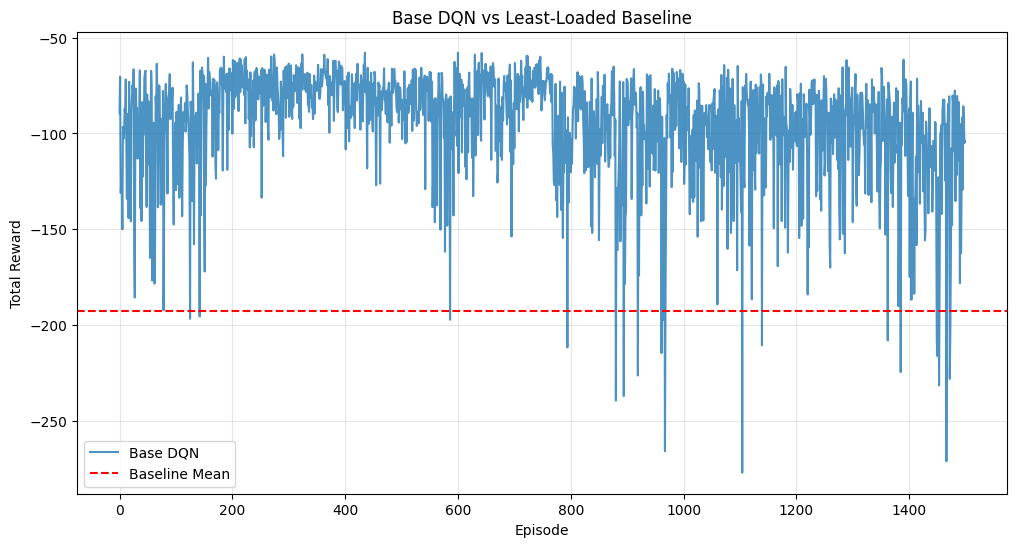

In [16]:
import gym
from gym import spaces
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import time
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------
# 1. Environment
# --------------------------
class EdgeResourceEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    def __init__(self, num_nodes=3, capacity=100.0, base_latency=1.0,
                 base_decay_rate=0.1, decay_jitter=0.03,
                 latency_penalty_power=2.0, overload_penalty_factor=5.0,
                 overload_threshold_factor=0.9, catastrophic_factor=1.1):
        super().__init__()
        self.num_nodes = num_nodes
        self.capacity = capacity
        self.base_latency = base_latency
        self.base_decay_rate = base_decay_rate
        self.decay_jitter = decay_jitter
        self.latency_penalty_power = latency_penalty_power
        self.overload_penalty_factor = overload_penalty_factor
        self.overload_threshold = overload_threshold_factor * self.capacity
        self.catastrophic_threshold = catastrophic_factor * self.capacity
        self.action_space = spaces.Discrete(num_nodes)
        self.observation_space = spaces.Box(low=0.0, high=1.0, shape=(num_nodes + 1,), dtype=np.float32)
        self.reset()

    def reset(self):
        self.node_loads = np.zeros(self.num_nodes, dtype=np.float32)
        self.current_task = self._generate_task()
        return self._get_state()

    def _generate_task(self):
        return float(np.random.normal(15.0, 6.0)) if random.random() > 0.12 else float(np.random.randint(40, 60))

    def _get_state(self):
        normalized_loads = np.clip(self.node_loads / self.capacity, 0.0, 1.0)
        norm_task = np.clip(self.current_task / self.capacity, 0.0, 1.0)
        return np.concatenate([normalized_loads, [norm_task]]).astype(np.float32)

    def step(self, action):
        self.node_loads *= (1.0 - (self.base_decay_rate + np.random.uniform(-self.decay_jitter, self.decay_jitter)))
        task_load = float(self.current_task)
        projected_load = self.node_loads[action] + task_load
        frac = projected_load / self.capacity
        latency = self.base_latency + (frac ** self.latency_penalty_power)
        overload_penalty = -self.overload_penalty_factor * (projected_load - self.overload_threshold)/self.capacity if projected_load > self.overload_threshold else 0.0
        loads_after = self.node_loads.copy()
        loads_after[action] += task_load
        std_penalty = -0.5 * np.std(loads_after) / self.capacity
        peak_reward = -1.0 * (np.max(loads_after)/self.capacity)
        reward = -latency + overload_penalty + std_penalty + peak_reward
        self.node_loads[action] += task_load
        done = projected_load > self.catastrophic_threshold
        if done: reward -= 50.0
        self.current_task = self._generate_task()
        return self._get_state(), float(reward), done, {"latency": latency}

# --------------------------
# 2. Weak Base DQN
# --------------------------
class BaseDQN(nn.Module):
    def __init__(self, state_size, action_size):
        super().__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.out = nn.Linear(64, action_size)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.out(x)

# --------------------------
# 3. Replay Buffer
# --------------------------
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return states, actions, rewards, next_states, dones
    def __len__(self):
        return len(self.buffer)

# --------------------------
# 4. Base DQN Training Loop
# --------------------------
def train_base_dqn(env, device, episodes=1500, steps=150, gamma=0.95,
                   lr=5e-5, batch_size=32, epsilon_start=1.0,
                   epsilon_min=0.05, epsilon_decay=0.992,
                   target_update_steps=1000, replay_capacity=10000):
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    policy_net = BaseDQN(state_size, action_size).to(device)
    target_net = BaseDQN(state_size, action_size).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()
    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    replay = ReplayBuffer(replay_capacity)
    epsilon = epsilon_start
    rewards_per_episode = []
    step_count = 0

    for ep in range(episodes):
        state = env.reset()
        total_reward = 0.0
        for t in range(steps):
            step_count += 1
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    st = torch.FloatTensor(state).unsqueeze(0).to(device)
                    action = int(policy_net(st).argmax().item())
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            replay.push(state, action, reward, next_state, done)
            state = next_state

            if len(replay) >= batch_size:
                states, actions, rewards, next_states, dones = replay.sample(batch_size)
                states_t = torch.FloatTensor(states).to(device)
                actions_t = torch.LongTensor(actions).unsqueeze(1).to(device)
                rewards_t = torch.FloatTensor(rewards).unsqueeze(1).to(device)
                next_states_t = torch.FloatTensor(next_states).to(device)
                dones_t = torch.FloatTensor(dones).unsqueeze(1).to(device)
                current_q = policy_net(states_t).gather(1, actions_t)
                with torch.no_grad():
                    next_q = target_net(next_states_t).max(1, keepdim=True)[0]
                    target_q = rewards_t + gamma * next_q * (1 - dones_t)
                loss = nn.MSELoss()(current_q, target_q)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                if step_count % target_update_steps == 0:
                    target_net.load_state_dict(policy_net.state_dict())

            if done: break

        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        rewards_per_episode.append(total_reward)

        if ep % 50 == 0 or ep == episodes-1:
            recent_avg = np.mean(rewards_per_episode[-50:]) if len(rewards_per_episode)>=50 else np.mean(rewards_per_episode)
            print(f"[{time.strftime('%H:%M:%S')}] Episode {ep}, Reward: {total_reward:.2f}, RecentAvg(50): {recent_avg:.2f}, Epsilon: {epsilon:.3f}")

    return rewards_per_episode

# --------------------------
# 5. Least-loaded baseline
# --------------------------
def baseline_least_loaded(env, episodes=500, steps=150):
    rewards = []
    for ep in range(episodes):
        state = env.reset()
        total = 0.0
        for _ in range(steps):
            action = int(np.argmin(env.node_loads))
            next_state, reward, done, _ = env.step(action)
            total += reward
            if done: break
        rewards.append(total)
    return rewards

# --------------------------
# 6. Run Training + Visualization
# --------------------------
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device)

    env = EdgeResourceEnv(num_nodes=3, latency_penalty_power=2.0,
                          overload_penalty_factor=5.0, overload_threshold_factor=0.9,
                          catastrophic_factor=1.05)

    # Train Base DQN
    base_rewards = train_base_dqn(env, device, episodes=1500, steps=150)
    least_loaded_rewards = baseline_least_loaded(env, episodes=500, steps=150)

    # Final Average Rewards
    print("\nAverage Reward (Base DQN, last 100 episodes):", np.mean(base_rewards[-100:]))
    print("Average Reward (Least Loaded, last 100 episodes):", np.mean(least_loaded_rewards[-100:]))

    # Statistical test
    stat, p_val = ttest_ind(base_rewards[-100:], least_loaded_rewards[-100:])
    print(f"t-test: t={stat:.4f}, p={p_val:.4f}")

    # Plot reward progression
    plt.figure(figsize=(12,6))
    plt.plot(base_rewards, label="Base DQN", alpha=0.8)
    plt.axhline(np.mean(least_loaded_rewards), color='r', linestyle='--', label="Baseline Mean")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Base DQN vs Least-Loaded Baseline")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
